In [ ]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy

from helpers import utils

In [ ]:
import zipfile
import os

def verify_unzip_file(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for file_name in zip_ref.namelist():
            if file_name.startswith('__MACOSX'):
                continue
            file_path = os.path.join(extract_to, file_name)
            if not os.path.exists(file_path):
                zip_ref.extract(file_name, extract_to)
                print(f"Extracted: {file_name}")
            # else:
            #     print(f"Skipped (already exists): {file_name}")

zip_path = "drive/MyDrive/deepship_baseline_unnorm_mat.zip"
extract_to = "data"

if not os.path.exists(extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

verify_unzip_file(zip_path, extract_to)

In [ ]:
irfan = keras.models.load_model("drive/MyDrive/saved_models/diff_spec_irfan/irfan_denoiser_50epochs.keras", custom_objects={'ssim': utils.ssim})
unet = keras.models.load_model("drive/MyDrive/saved_models/diff_spec_unet/unet_denoiser_50epochs.keras", custom_objects={'ssim': utils.ssim})

In [ ]:
np.random.seed(39)

# Get 1 spectrogram from each class
files = []
for cls in ['Cargo', 'Passengership', 'Tanker', 'Tug']:
    random_file = np.random.choice(os.listdir(f"data/{cls}"))
    file_path = "data" + "/" + cls + "/" + random_file
    files.append(file_path)

print(files)

['data/Cargo/TRITON_HAWK-70-20171117_seg014.mat', 'data/Passengership/COASTAL_INSPIRATION-60-20180205_seg085.mat', 'data/Tanker/AGNES_VICTORY-80-20180330_seg025.mat', 'data/Tug/SEASPAN_QUEEN-52-20171120_seg187.mat']


In [ ]:
input_specs = []
for file in files:
    X = scipy.io.loadmat(file)['Ptrans']
    X = np.expand_dims(X, axis=-1)

    X_min = X.min(axis=(0, 1), keepdims=True)
    X_max = X.max(axis=(0, 1), keepdims=True)
    X = (X - X_min) / (X_max - X_min)

    X = X.astype(np.float32)

    input_specs.append(X)

input_specs = np.array(input_specs)
print(input_specs.shape)

(4, 192, 192, 1)


In [ ]:
irfan_predictions = irfan.predict(input_specs)
unet_predictions = unet.predict(input_specs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [ ]:
# Check if all outputs are normalised
for i, output in enumerate(irfan_predictions):
    print(f"Sample {i+1} - Min: {np.min(output)}; Max: {np.max(output)}")
for i, output in enumerate(unet_predictions):
    print(f"Sample {i+1} - Min: {np.min(output)}; Max: {np.max(output)}")

Sample 1 - Min: 0.3338375687599182; Max: 0.7829792499542236
Sample 2 - Min: 0.38968178629875183; Max: 0.7860385179519653
Sample 3 - Min: 0.3487318456172943; Max: 0.771080732345581
Sample 4 - Min: 0.38560909032821655; Max: 0.8088093996047974
Sample 1 - Min: 0.3213216960430145; Max: 0.7727282047271729
Sample 2 - Min: 0.41591161489486694; Max: 0.794497549533844
Sample 3 - Min: 0.3146662414073944; Max: 0.7718393206596375
Sample 4 - Min: 0.400180846452713; Max: 0.8037216663360596


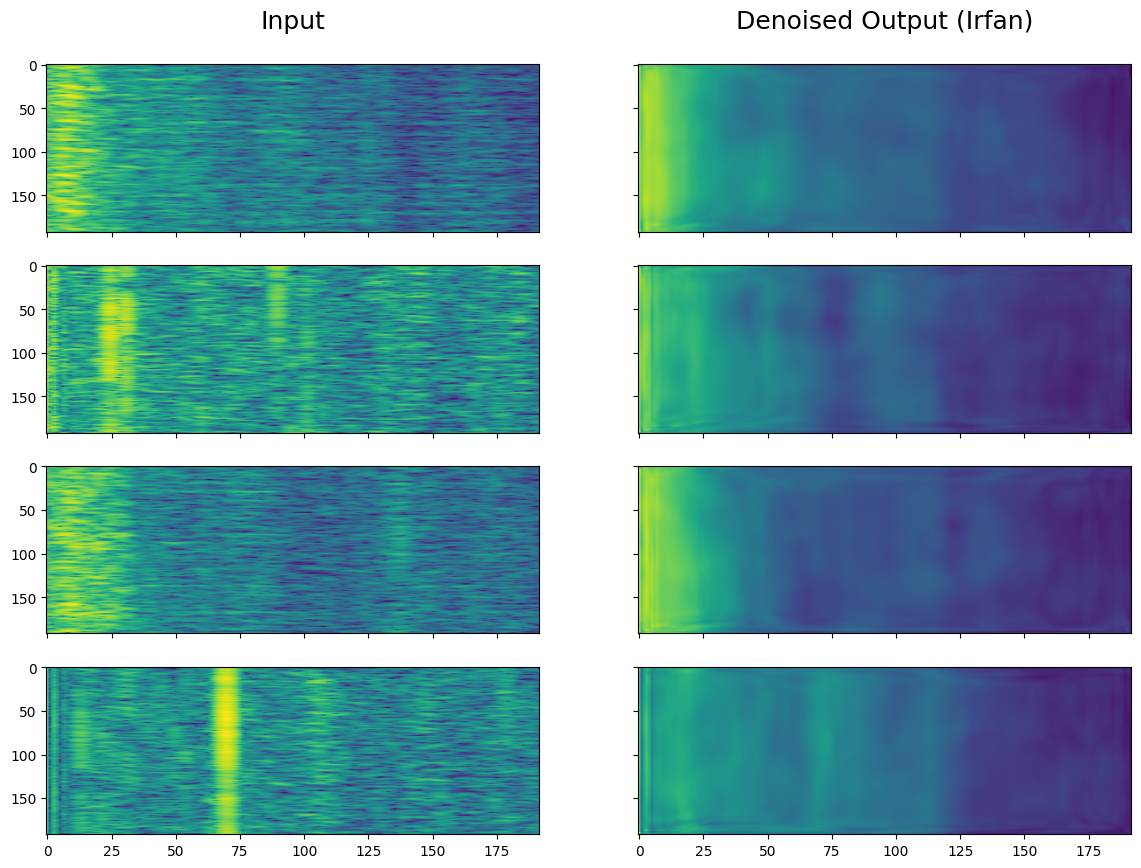

In [ ]:
# Create a single figure
fig, axes = plt.subplots(4, 2, figsize=(14, 10), sharex=True, sharey=True)

for i in range(4):
    axes[i, 0].imshow(input_specs[i].squeeze(), cmap="viridis", aspect="auto")
    axes[i, 1].imshow(irfan_predictions[i].squeeze(), cmap="viridis", aspect="auto")

axes[0, 0].set_title(f"Input\n", fontsize=18)
axes[0, 1].set_title(f"Denoised Output (Irfan)\n", fontsize=18)

# fig.tight_layout(pad=1.5)
# fig.savefig(f"drive/MyDrive/saved_models/diff_spec_irfan/img/combined_spectrograms.pdf", bbox_inches="tight")

plt.show()